In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('png', dpi=200)
sns.set_style('darkgrid')
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, classification_report
import plotly.graph_objects as go

### Gaussian 模型

In [2]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [3]:
# 定义朴素贝叶斯模型
model = GaussianNB()

# 定义参数网格
param_grid = {
    'var_smoothing': np.logspace(start=-10, stop=0, num=50)
}

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e-10, 1.59985872e-10, 2.55954792e-10, 4.09491506e-10,
       6.55128557e-10, 1.04811313e-09, 1.67683294e-09, 2.68269580e-09,
       4.29193426e-09, 6.86648845e-09, 1.09854114e-08, 1.75751062e-08,
       2.81176870e-08, 4.49843267e-08, 7.19685673e-08, 1.15139540e-07,
       1.84206997e-07, 2.94705170e-07, 4.71...
       7.90604321e-06, 1.26485522e-05, 2.02358965e-05, 3.23745754e-05,
       5.17947468e-05, 8.28642773e-05, 1.32571137e-04, 2.12095089e-04,
       3.39322177e-04, 5.42867544e-04, 8.68511374e-04, 1.38949549e-03,
       2.22299648e-03, 3.55648031e-03, 5.68986603e-03, 9.10298178e-03,
       1.45634848e-02, 2.32995181e-02, 3.72759372e-02, 5.96362332e-02,
       9.54095476e-02, 1.52641797e-01, 2.44205309e-01, 3.90693994e-01,
       6.25055193e-01, 1.00000000e+00])})

In [4]:
# 获取网格搜索结果
results = grid_search.cv_results_
params = results['params']
mean_scores = results['mean_test_score']

# 绘制var_smoothing参数对应的平均得分曲线
fig = go.Figure(data=go.Scatter(
    x=[params[i]['var_smoothing'] for i in range(len(params))],
    y=mean_scores,
    mode='lines+markers'
))
fig.update_layout(
    title='Naive Bayes Parameter Tuning',
    xaxis=dict(title='var_smoothing'),
    yaxis=dict(title='Mean Test Score'),
    font=dict(family='Times New Roman', size=18)
)

fig.write_html('Image/4_4_1.html')
fig.show()

In [5]:
lr_model = grid_search.best_estimator_

In [6]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88     11190
           1       0.72      0.33      0.45      3700

    accuracy                           0.80     14890
   macro avg       0.76      0.64      0.66     14890
weighted avg       0.79      0.80      0.77     14890



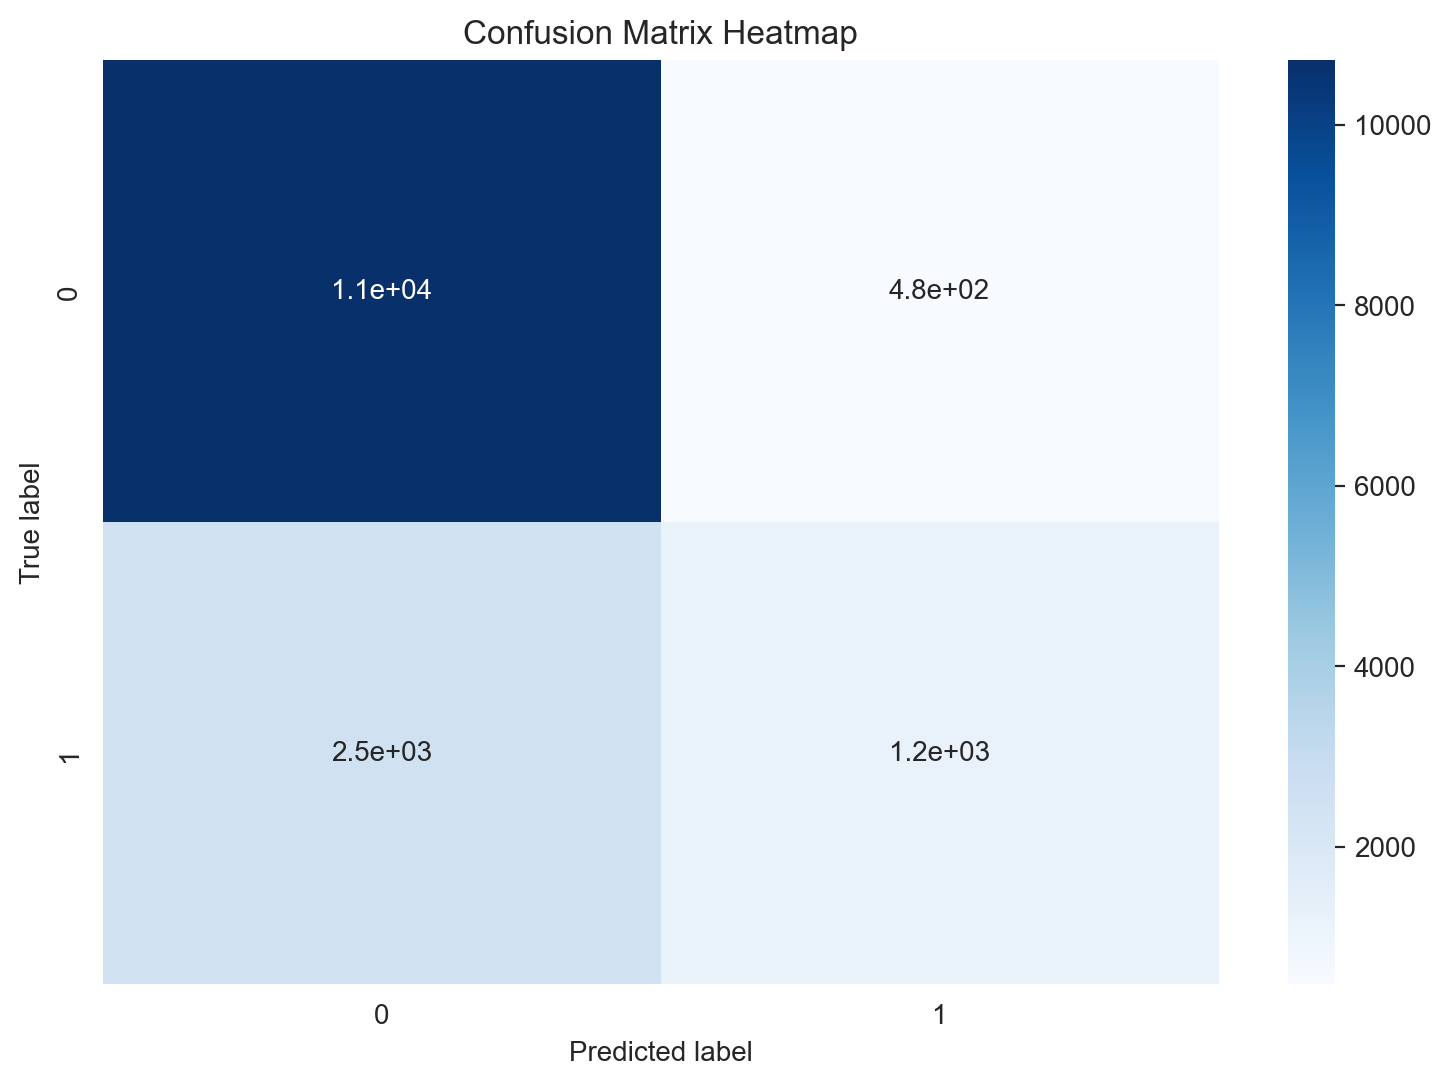

In [8]:
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [9]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_4_2.html')
# 显示图表
fig.show()

In [10]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_4_3.html')
fig.show()

### 过采样和欠采样

In [11]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')

In [12]:
from imblearn.under_sampling import RandomUnderSampler

In [13]:
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [14]:
# 创建欠采样器
rus = RandomUnderSampler(random_state=42)

# 进行欠采样
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [15]:
# 定义朴素贝叶斯模型
model = GaussianNB()

# 定义参数网格
param_grid = {
    'var_smoothing': np.logspace(start=-10, stop=0, num=50)
}

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
lr_model = grid_search.best_estimator_

In [16]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88     11190
           1       0.72      0.33      0.45      3700

    accuracy                           0.80     14890
   macro avg       0.76      0.64      0.66     14890
weighted avg       0.79      0.80      0.77     14890



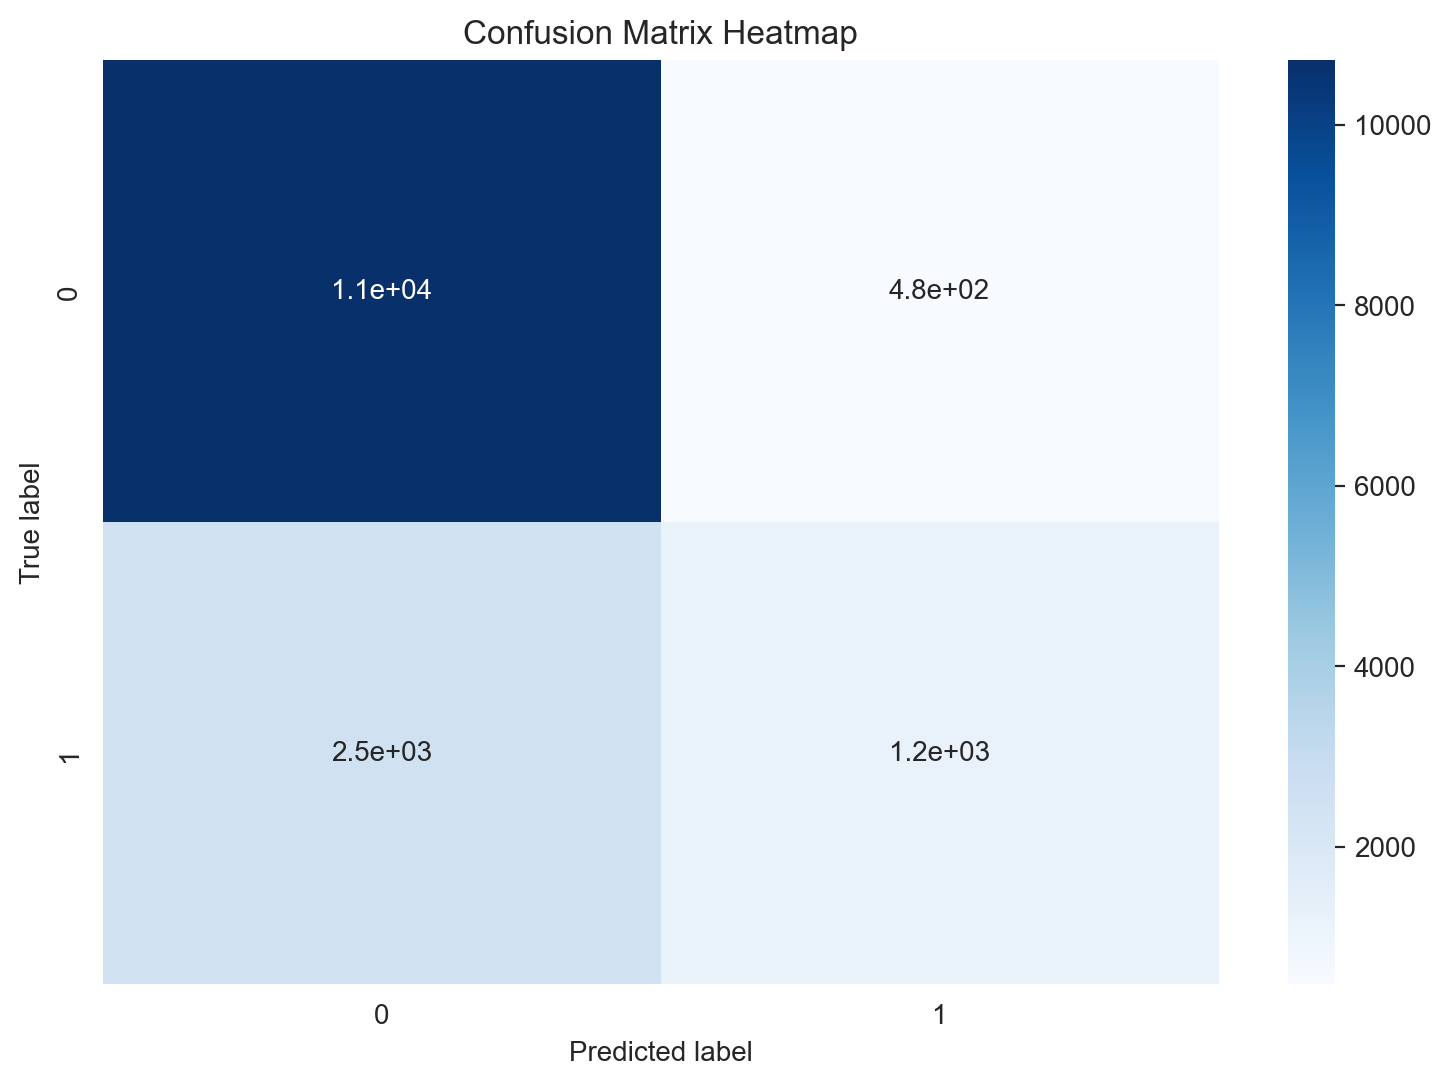

In [18]:
# %%
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [19]:
# %%
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_4_4.html')
# 显示图表
fig.show()

In [20]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_4_5.html')
fig.show()

In [21]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')

In [22]:
from imblearn.over_sampling import RandomOverSampler

In [23]:
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [24]:
# 创建过采样器
ros = RandomOverSampler(random_state=42)

# 进行过采样
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [25]:
# 定义朴素贝叶斯模型
model = GaussianNB()

# 定义参数网格
param_grid = {
    'var_smoothing': np.logspace(start=-10, stop=0, num=50)
}

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
lr_model = grid_search.best_estimator_

In [26]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88     11190
           1       0.72      0.33      0.45      3700

    accuracy                           0.80     14890
   macro avg       0.76      0.64      0.66     14890
weighted avg       0.79      0.80      0.77     14890



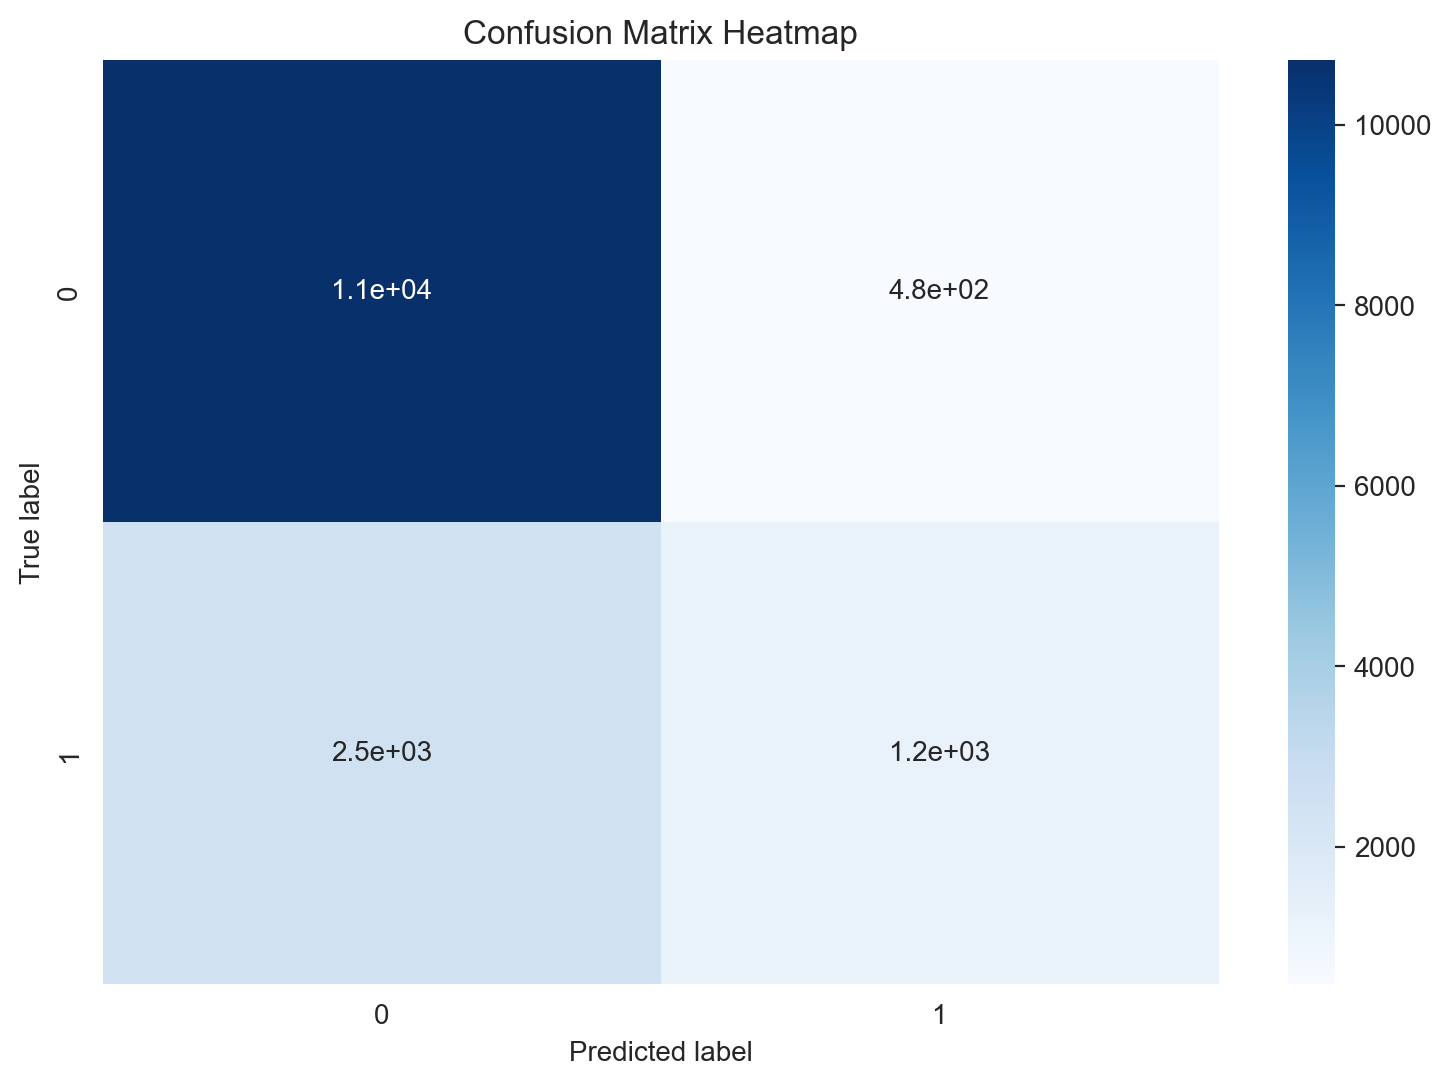

In [28]:
# %%
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [29]:
# %%
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_4_6.html')
# 显示图表
fig.show()

In [30]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_4_7.html')
fig.show()

### 类别权重: 关注少数类别。

In [31]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')
X_train, y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]
X_test, y_test = test_data.iloc[:, :-1], test_data.iloc[:, -1]

In [32]:
class_counts = y_train.value_counts()
class_counts

0    22305
1     7506
Name: income, dtype: int64

In [33]:

from sklearn.utils import class_weight

# 计算每个类别的权重
class_weights = class_weight.compute_class_weight('balanced', classes=class_counts.index, y=y_train)
class_weights = dict(zip(class_counts.index, class_weights))
class_weights

{0: 0.6682582380632145, 1: 1.9858113509192645}

In [34]:
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [35]:
# 定义朴素贝叶斯模型
model = GaussianNB()

# 定义参数网格
param_grid = {
    'var_smoothing': np.logspace(start=-10, stop=0, num=50)
}

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
lr_model = grid_search.best_estimator_

In [36]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88     11190
           1       0.72      0.33      0.45      3700

    accuracy                           0.80     14890
   macro avg       0.76      0.64      0.66     14890
weighted avg       0.79      0.80      0.77     14890



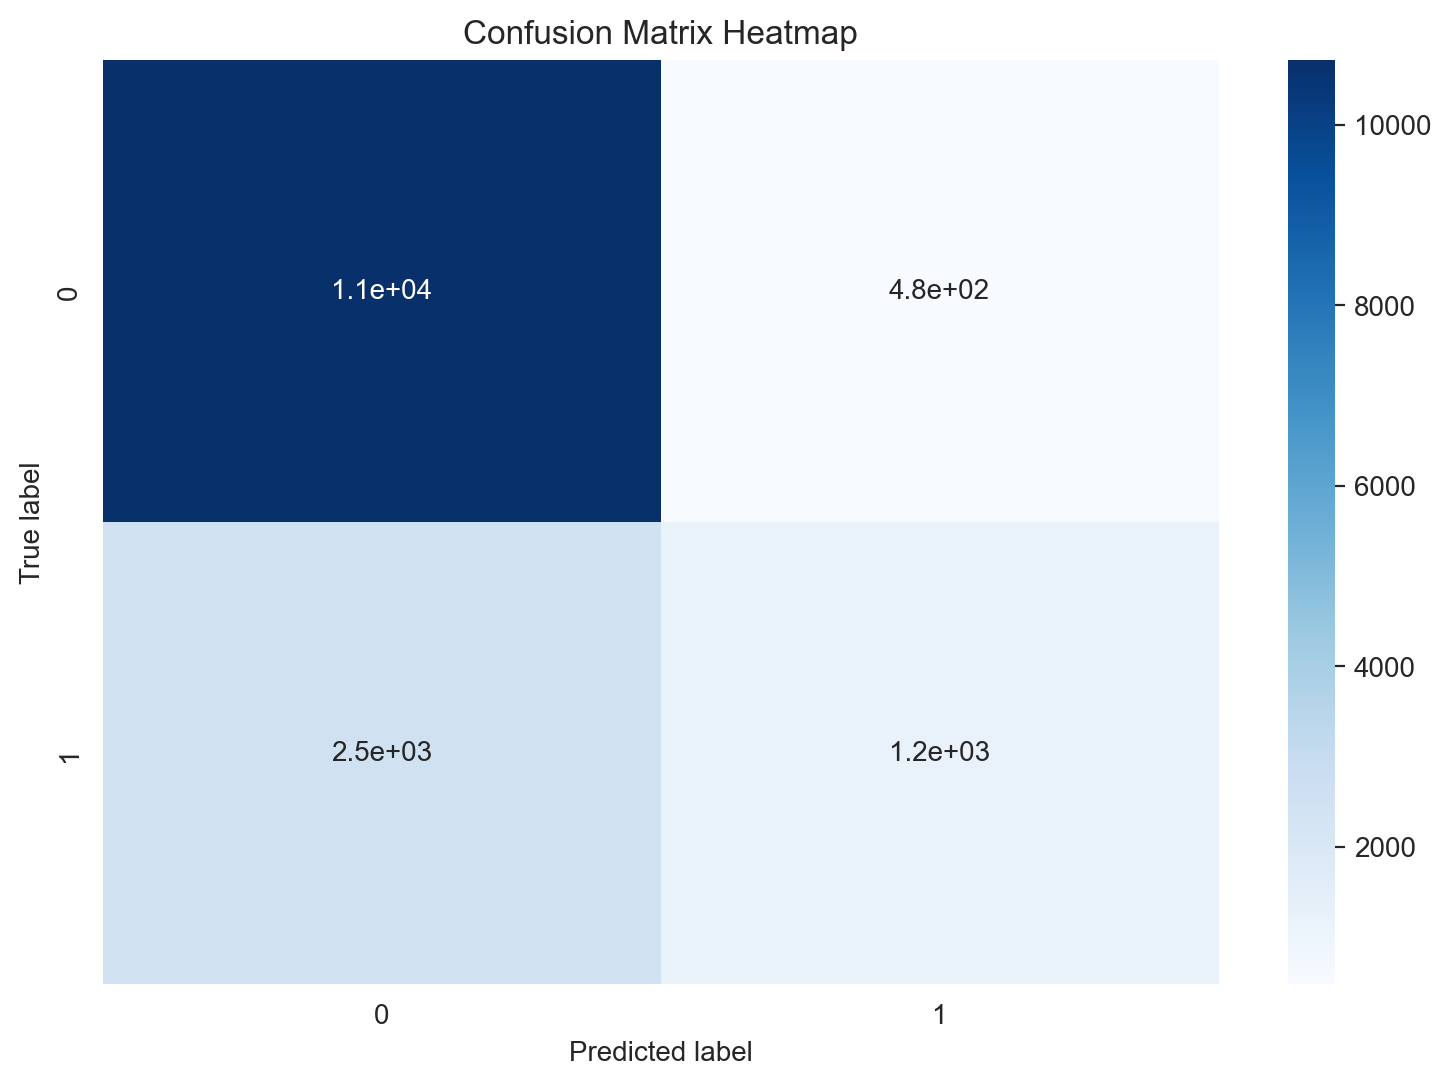

In [38]:
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [39]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_4_8.html')
# 显示图表
fig.show()

In [40]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_4_9.html')
fig.show()
"""
当精确率（Precision）较高而召回率（Recall）较低时，意味着模型在预测为正类的样本中有较高的准确性，但同时错过了一些真实的正类样本。

具体解释如下：

高精确率：模型预测为正类的样本中，有很高比例的样本实际上是真正的正类样本。这表示模型对于正类的预测是相对可靠和准确的。
低召回率：模型未能正确识别出所有真实的正类样本，一些正类样本被错误地预测为负类或被漏掉了。这表示模型在正类样本的识别上存在一定的缺陷。
这种情况常见于模型对正类样本的判别标准较高，导致了较多的假阴性（False Negative）和较少的假阳性（False Positive）。换句话说，模型更倾向于保守地将样本预测为负类，以确保预测的准确性，但这也导致了一些真实的正类样本被错过。

具体如何解释这种情况需要结合具体业务场景来分析。如果在某些场景中，假阳性的代价比假阴性高，那么高精确率可能是可以接受的，因为模型确保尽可能减少了错误的预测为正类的情况。然而，如果在某些场景中，假阴性的代价比假阳性高，那么需要关注如何提高召回率，以确保更多真实的正类样本被正确地预测出来。

综合考虑精确率和召回率，可以使用F1分数来评估模型的综合性能，F1分数综合了精确率和召回率，对两者都有要求。在某些情况下，可能需要在精确率和召回率之间进行权衡，选择最适合特定场景需求的模型性能指标。
"""

'\n当精确率（Precision）较高而召回率（Recall）较低时，意味着模型在预测为正类的样本中有较高的准确性，但同时错过了一些真实的正类样本。\n\n具体解释如下：\n\n高精确率：模型预测为正类的样本中，有很高比例的样本实际上是真正的正类样本。这表示模型对于正类的预测是相对可靠和准确的。\n低召回率：模型未能正确识别出所有真实的正类样本，一些正类样本被错误地预测为负类或被漏掉了。这表示模型在正类样本的识别上存在一定的缺陷。\n这种情况常见于模型对正类样本的判别标准较高，导致了较多的假阴性（False Negative）和较少的假阳性（False Positive）。换句话说，模型更倾向于保守地将样本预测为负类，以确保预测的准确性，但这也导致了一些真实的正类样本被错过。\n\n具体如何解释这种情况需要结合具体业务场景来分析。如果在某些场景中，假阳性的代价比假阴性高，那么高精确率可能是可以接受的，因为模型确保尽可能减少了错误的预测为正类的情况。然而，如果在某些场景中，假阴性的代价比假阳性高，那么需要关注如何提高召回率，以确保更多真实的正类样本被正确地预测出来。\n\n综合考虑精确率和召回率，可以使用F1分数来评估模型的综合性能，F1分数综合了精确率和召回率，对两者都有要求。在某些情况下，可能需要在精确率和召回率之间进行权衡，选择最适合特定场景需求的模型性能指标。\n'

### 降维

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

In [42]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')
X_train, y_train = pca.fit_transform(train_data.iloc[:, :-1]), train_data.iloc[:, -1].values
X_test, y_test = pca.fit_transform(test_data.iloc[:, :-1]), test_data.iloc[:, -1].values

In [43]:
# 定义朴素贝叶斯模型
model = GaussianNB()

# 定义参数网格
param_grid = {
    'var_smoothing': np.logspace(start=-10, stop=0, num=50)
}

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
lr_model = grid_search.best_estimator_

In [44]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.94      0.86     11190
           1       0.59      0.27      0.37      3700

    accuracy                           0.77     14890
   macro avg       0.69      0.61      0.62     14890
weighted avg       0.74      0.77      0.74     14890



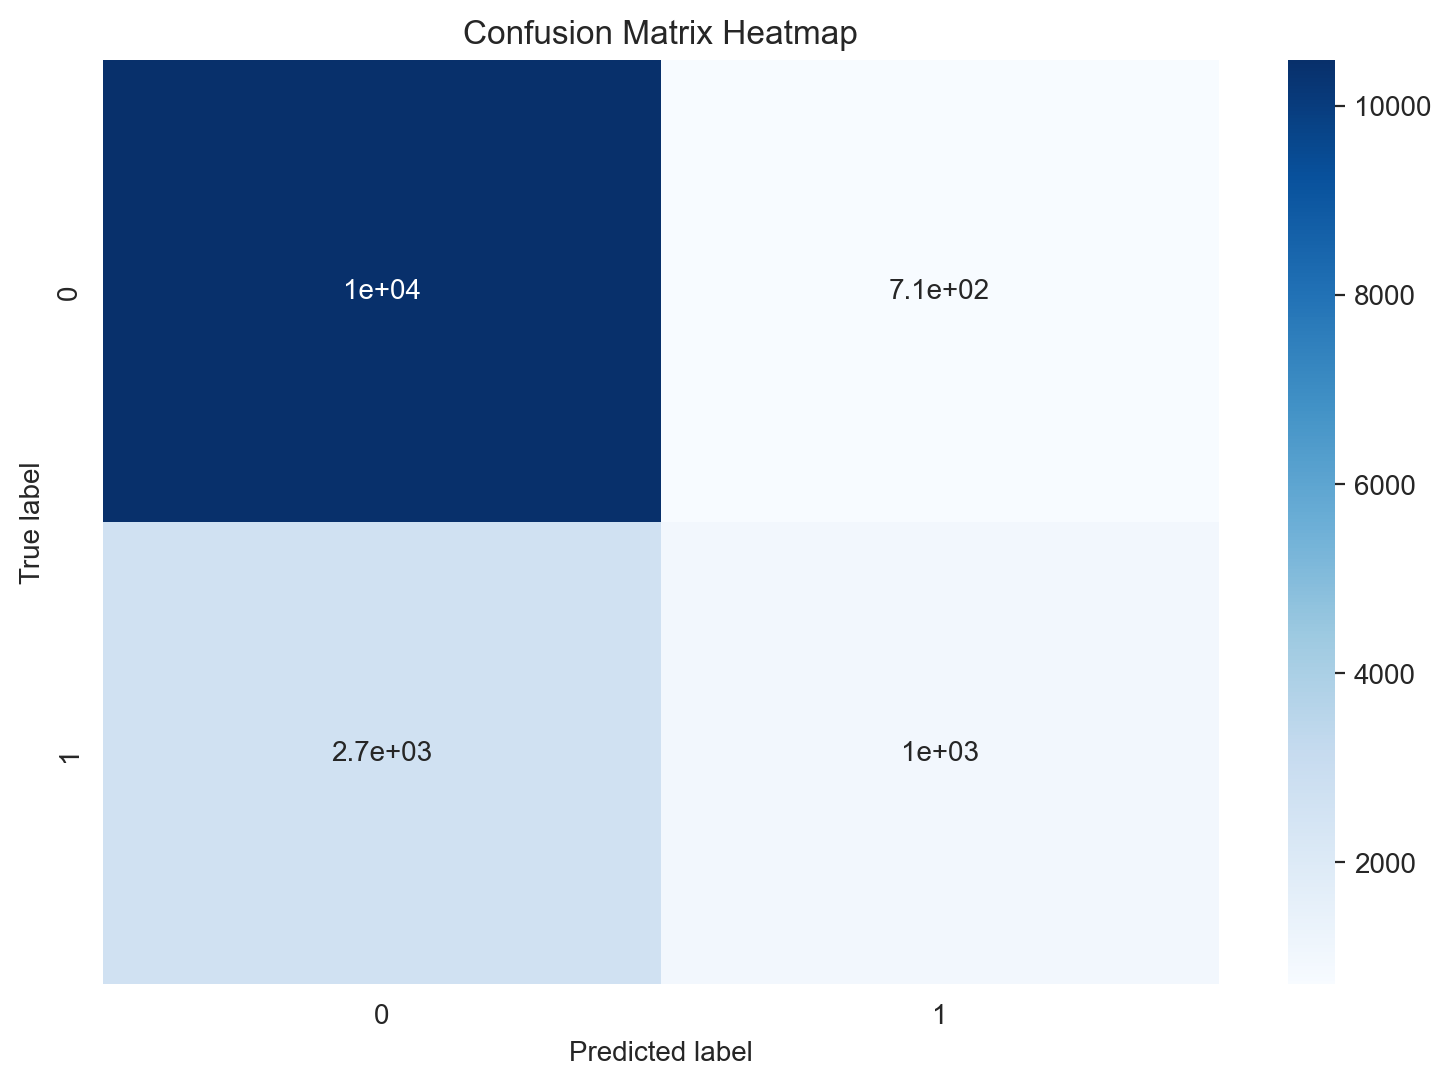

In [46]:
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [47]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_4_10.html')
# 显示图表
fig.show()

In [48]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_4_11.html')
fig.show()